# Testing degradation on ABC vs true distribution

In [3]:
import pints
import pints.toy as toy
import pints.toy.stochastic
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

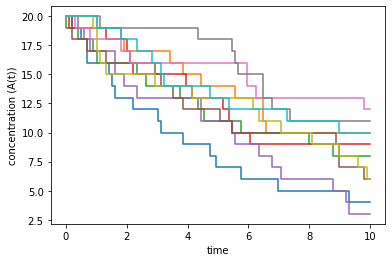

In [2]:
np.random.seed(3)

# Load a forward model
model = toy.stochastic.DegradationModel()

# Create some toy data
real_parameters = model.suggested_parameters()
times = np.linspace(0, 10, 100)

for i in range(10):
    values = model.simulate(real_parameters, times)

    # Create an object with links to the model and time series
    problem = pints.SingleOutputProblem(model, times, values)

    # Create a uniform prior parameter
    log_prior = pints.UniformLogPrior([0.0], [0.3])

    # Set the error measure to be used to compare simulated to observed data
    error_measure = pints.RootMeanSquaredError(problem)

    plt.step(times, values)


plt.xlabel('time')
plt.ylabel('concentration (A(t))')
plt.show()

In [10]:
from math import comb

n_0 = 20

def compute_prob(n, t, k):
    exp_term = np.exp(-k * n * t)
    comb_term = comb(n_0, int(n)) 
    t_term = (1 - np.exp(-k * t)) 
    return exp_term * comb_term * (t_term ** (n_0 - n))

def prob_gen(data, times, k):
    all_prob = 0
    for i in range(len(data)):
        computed_prob = compute_prob(data[i][0], times[i], k)
        all_prob += np.log(computed_prob)
    return all_prob

thetas = np.linspace(0.01, 0.3, 30)
true_prob = []
for i in range(len(thetas)):
    true_prob.append(prob_gen(values, times, thetas[i]))

# Adjust to be positive
addition = np.amin(true_prob)
for i in range(len(true_prob)):
    true_prob[i] -= addition
    # true_prob[i] *= 2

1.0


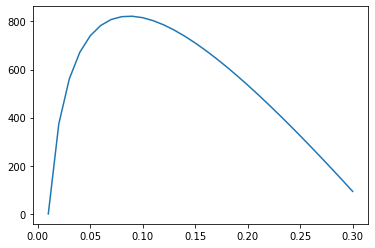

In [11]:
print(compute_prob(20, 1, 0))
plt.plot(thetas, true_prob)
plt.show()

# Rejection ABC

In [6]:
abc = pints.ABCController(error_measure, log_prior)

# set threshold
abc.sampler().set_threshold(1)

# set target number of samples
abc.set_n_samples(10000)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using Rejection ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     18     0.0555555556     0:00.0
2     35     0.0571428571     0:00.0
3     206    0.0145631068     0:00.1
20    828    0.0241545894     0:00.3
40    1843   0.0217037439     0:00.6
60    3011   0.0199269346     0:01.0
80    4047   0.0197677292     0:01.3
100   4900   0.0204081633     0:01.6
120   5568   0.0215517241     0:01.7
140   6715   0.0208488459     0:02.1
160   7800   0.0205128205     0:02.4
180   8481   0.0212239123     0:02.6
200   10047  0.0199064397     0:03.1
220   11393  0.0193101027     0:03.5
240   12878  0.0186364342     0:03.9
260   13961  0.0186233078     0:04.3
280   14842  0.018865382      0:04.6
300   16001  0.0187488282     0:04.9
320   16994  0.0188301754     0:05.2
340   18446  0.0184321804     0:05.7
360   19235  0.0187158825     0:06.0
380   20440  0.018590998      0:06.7
400   21418  0.0186758801     0:07.1
420   22161  0.0189522133     0:07.3
440   23508  0.0

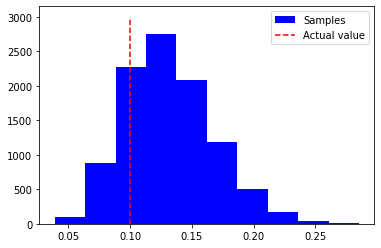

In [27]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=3000, label="Actual value", color="red")
# plt.plot(thetas, true_prob, label="posterior")
plt.legend()
plt.show()

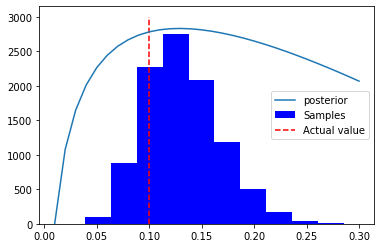

In [28]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=3000, label="Actual value", color="red")
plt.plot(thetas, true_prob, label="posterior")
plt.legend()
plt.show()

# PMC Degradation

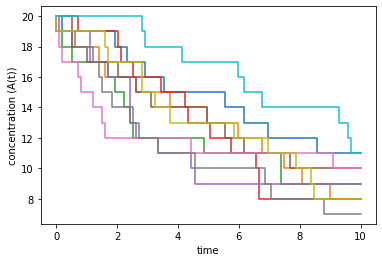

In [14]:
np.random.seed(3)
# Load a forward model
model = toy.stochastic.DegradationModel()
# Create some toy data
real_parameters = model.suggested_parameters()
times = np.linspace(0, 10, 100)
for i in range(10):
    values = model.simulate(real_parameters, times)
    # Create an object with links to the model and time series
    problem = pints.SingleOutputProblem(model, times, values)
    # Create a uniform prior parameter
    log_prior = pints.UniformLogPrior([0.0], [0.3])
    # Set the error measure to be used to compare simulated to observed data
    error_measure = pints.RootMeanSquaredError(problem)
    plt.step(times, values)

plt.xlabel('time')
plt.ylabel('concentration (A(t))')
plt.show()

In [8]:
np.random.seed(3)

abc = pints.ABCController(error_measure, log_prior, method=pints.ABCPMC)

# set the threshold
abc.sampler().set_threshold(1)

# set target number of samples
# try this
abc.set_n_samples(1000)

# setting the number of generations
abc.sampler().set_n_generations(20)

# setting the threshold ratio
abc.sampler().set_t_ratio(0.99)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using PMC ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     122638  0.00163896998    3:23.5
Halting: target number of samples (201) reached.
Done


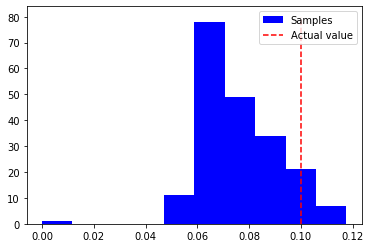

In [9]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=80, label="Actual value", color="red")
# plt.plot(thetas, true_prob, label="posterior")
plt.legend()
plt.show()